In [1]:
from functools import partial

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrng 

from jax import Array

import matplotlib.pyplot as plt

jnp.set_printoptions(precision=3)

In [2]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations

key = jrng.key(seed)
key, O_key, mu_key = jrng.split(key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.99 * jnp.eye(n)
T = T + 0.01 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(- 5 * jnp.arange(0, n))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jrng.uniform(O_key, (n, m))
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


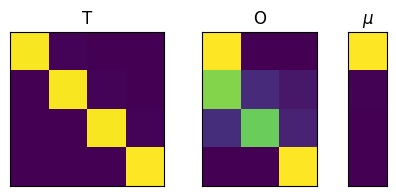

In [3]:
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(5,2)
ax[0].imshow(T)
ax[0].set_title("T")
ax[1].imshow(O)
ax[1].set_title("O")
ax[2].imshow(mu[:,None])
ax[2].set_title(r"$\mu$")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

In [4]:
from baum_welch_jax.algorithms import generate_sequence


In [5]:
n_sequences = 10_000
len_sequence = 500
key, *sequence_keys = jrng.split(key, 1 + n_sequences)

result = jax.vmap(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))(jnp.array(sequence_keys))

In [6]:
states, observations = result
states.shape

(10000, 500)

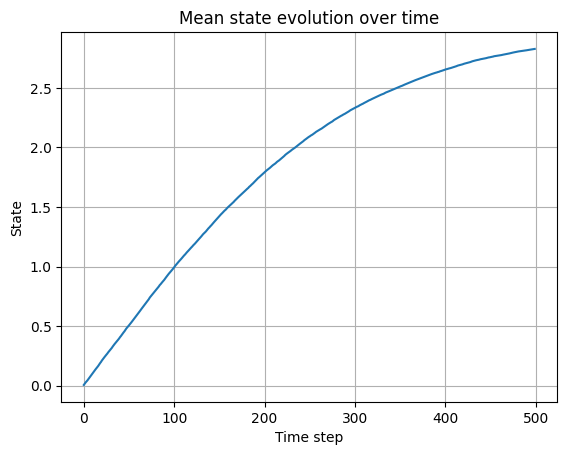

In [7]:
plt.title("Mean state evolution over time")
plt.plot(jnp.mean(states, axis=0))
plt.grid()
plt.xlabel("Time step")
plt.ylabel("State")
plt.show()

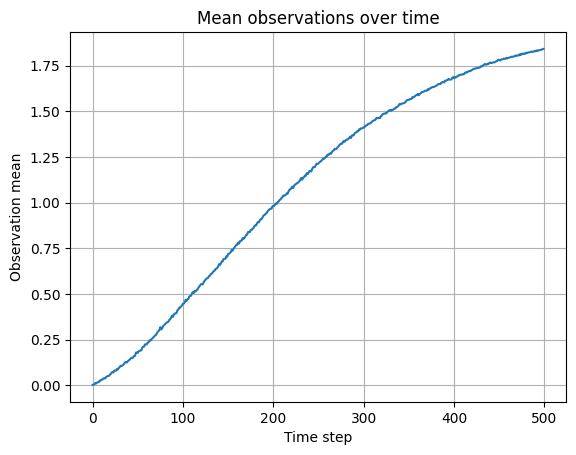

In [8]:
plt.title("Mean observations over time")
plt.plot(jnp.mean(observations, axis=0))
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Observation mean")
plt.show()

In [9]:
def joint_likelihood(distributions, obs):
    """
    Computes the joint liklihood of a sequence of observations given the distributions T, O and mu
    """
    T, O, mu = (distributions["T"], distributions["O"], distributions["mu"])
    initial_carry = {
        "carry_factor" : mu.T,
        "likelihood" : 1.0
    }


    def loop_body(carry, obs):
        
        factor = carry["carry_factor"]
        llhood = carry["likelihood"]

        state_distribution = factor @ T
        obs_distr = state_distribution @ O
        new_llhood = llhood * obs_distr[obs] / jnp.sum(obs_distr)

        return (
            {
            "carry_factor" : state_distribution * O[:, obs],
            "likelihood" : new_llhood
            },  
            new_llhood 
        )
        

    _, likelihoods  = lax.scan(
        loop_body,
        initial_carry,
        obs,
        unroll=False
        )
    

    return likelihoods

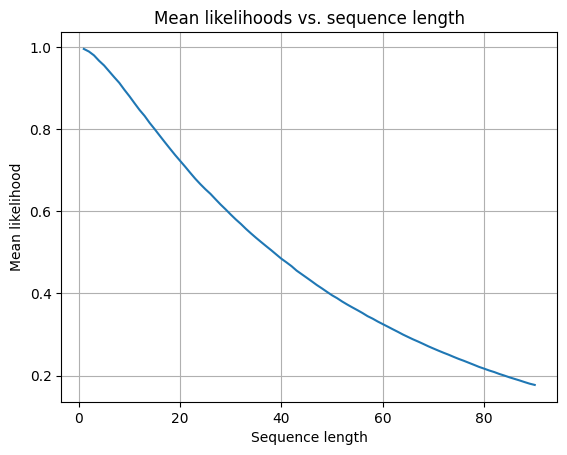

In [10]:
sample_length = 90
distributions = {"T" : T, "O" : O, "mu" : mu}
likelihoods = jax.vmap(lambda obs_seq: joint_likelihood(distributions, obs_seq))(observations[:, :sample_length])

plt.title("Mean likelihoods vs. sequence length")
plt.plot(jnp.arange(1, sample_length + 1), jnp.mean(likelihoods, axis=0))
plt.xlabel("Sequence length")
plt.ylabel("Mean likelihood")
plt.grid()
plt.show()

# Forward-Backward algorithm

The forward backward algorithm estimates the hidden parameters $T$ and $O$ of an HMM given a sequence of observations $o_1, \dots, o_T$ and the initial state distribution $\mu$.

It performs the following steps (assuming the initial state distribution $\mu$ is known):


1. Initialize $T, O$ in a smart way (otherwise might fail to converge)
2. **Expecatation step:**
    
    Compute $$\gamma_{t, j} = \frac{\alpha_{t,j} \beta_{t,j}}{p(o_1, \dots, o_T | T, O, \mu)}$$
    Compute $$\xi_{t, i, j} = \frac{\alpha_{t, i} T_{i,j} O_{j, o_{t+1}} \beta_{t +1, j}}{p(o_1, \dots, o_T | T, O, \mu)}$$

3. **Maximization step:**
    Compute new estimates of $T$ and $O$ in the following way:

    $$T_{i,j} = \frac{\sum_{t=1}^{T - 1} \xi_{t, i , j}}{\sum_{t=1}^{T - 1}\sum_{k=1}^{n} \xi_{t, i, k}}$$

    and

    $$O_{j, k} = \frac{\sum_{t=1, o_t = k}^T \gamma_{t, j}}{\sum_{t=1}^T \gamma_{t, j}}$$

4. If not converged, go to 2, else return $T$, $O$


The computation of $\alpha_{t,j}$ and $\beta_{t,j}$ work like this:

$$\alpha_{t, j} = \sum_{i=1}^n \alpha_{t-1, i} T_{i, j} O_{j, o_t} \Rightarrow \alpha_{t} = \alpha_{t-1} T \odot O_{:, o_t}$$

where $\alpha_1 = \mu \odot O_{:, o1}$. Also note that the likelihood of the entire sequence of observations $p(o_1, \dots, o_T | T, O, \mu)$ is given by

$$ p(o_1, \dots, o_T | T, O, \mu) = \sum_{i = 1}^n \alpha_{T, i} $$

For $\beta_t$:

$$\beta_{t, i} = \sum_{j = 1}^{n} T_{i,j} O_{j, o_{t+1}} \beta_{t +1} \Rightarrow \beta_{t} = T (O_{:, o_{t+1}} \odot \beta_{t + 1})$$

where $\beta_{T} = \mathbf{1}$ and also

$$ p(o_1, \dots, o_T | T, O, \mu) = \sum_{j = 1}^n \mu_j O_{j, o_1} \beta_{1, j} $$

The above formulas allow for a naive implementation of the algorithm.

Note that the calculation of $\gamma$ is an elementwise product of $\alpha$ and $\beta$, divided by the likelihood of the sequence (i.e. $\sum_j \alpha_{T,j}$)

Calculation of $\xi_t$ can be realized as so:

$$\xi_{t, i, j} = \frac{\alpha_{t, i} T_{i,j} O_{j, o_{t+1}} \beta_{t +1, j}}{p(o_1, \dots, o_T | T, O, \mu)}
\Rightarrow \xi_t = T \odot ( \alpha_t \cdot (O_{:, o_{t+1}} \odot \beta_{t + 1}))$$

where the product $\alpha_t \cdot (O_{:, o_{t+1}} \odot \beta_{t + 1})$ is the outer product, resulting in an $n \times n$ matrix.

In [11]:
import numpy as np

def forward_backward_naive(obs, mu, T_0, O_0, max_iter=100):
    t_max = len(obs)

    _T = np.array(T_0.copy())
    _O = np.array(O_0.copy())

    n, m = _O.shape

    for _ in range(max_iter):
        alpha = np.zeros((t_max, n))
        beta = np.ones((t_max, n))
        ovec = np.zeros((t_max, n))

        alpha[0] = mu * _O[:, obs[0]]
        alpha[0] = alpha[0] / np.sum(alpha[0])
        for t in range(1, t_max):
            alpha[t] = (alpha[t - 1] @ _T) * _O[:, obs[t]]
            ovec[t_max - t] = _O[:, obs[t_max - t]]
            beta[t_max - t - 1] = _T @ (ovec[t_max - t] * beta[t_max - t])
            
            sum_alpha = np.sum(alpha[t])
            sum_beta = np.sum(beta[t_max - t - 1])

            if sum_alpha != 0:
                alpha[t] = alpha[t] / np.sum(alpha[t])
            if sum_beta != 0:
                beta[t_max - t - 1] = beta[t_max - t - 1] / np.sum(beta[t_max - t - 1])

        beta[t_max - 1] = beta[t_max - 1] / np.sum(beta[t_max - 1]) 

        likelihood = np.sum(alpha[t_max - 1])
        gamma = (alpha * beta) / likelihood

        xi = np.einsum("ij, ik->ijk", alpha[:-1], beta[1:] * ovec[1:])
        xi = xi * _T[None, ...]

        _T = np.sum(xi, axis=0) 
        _T = _T / np.sum(xi, axis=(0, -1))[..., None]

        for o in range(m):
            idx_filter = (obs == o)
            _O[:, o] = np.sum(gamma[idx_filter], axis=0)
        
        _O = _O / np.sum(gamma, axis=0)[..., None]
        

    return _T, _O

test_obs = observations[1, :1000]

key, key_0, key_1 = jrng.split(key, 3)

_T, _O, = forward_backward_naive(test_obs, mu, jnp.triu(jrng.uniform(key_0, T.shape)), jrng.uniform(key_1, O.shape))

Note that $\alpha$ and $\beta$ are normalized in each step to avoid underflow! (TODO: Explain exactly why we can do this!)

[1. 1. 1. 1.]
[1. 1. 1. 1.]


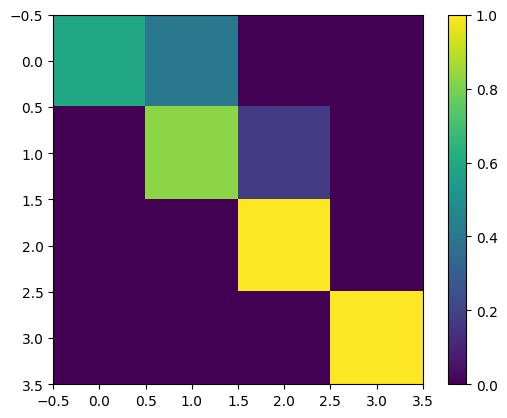

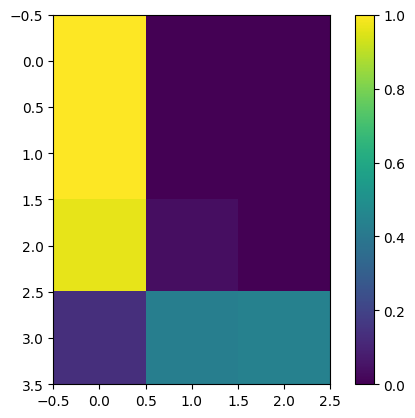

In [12]:
print(np.sum(_T, axis=-1))
print(np.sum(_O, axis=-1))

plt.imshow(_T)
plt.colorbar()
plt.show()
plt.imshow(_O)
plt.colorbar()
plt.show()

### Running an experiment

We are now ready to run an experiment. as an initialization, we choose uniformly random sampled matrices, but we at least specify that $T$ must have upper diagonal shape. 

In [13]:
from tqdm import tqdm
n_trials = 50

T_arr = np.zeros((n_trials, n, n))
O_arr = np.zeros((n_trials, n, m))

for trial in tqdm(range(n_trials)):
    test_obs = observations[trial, :100]

    key, key_0, key_1 = jrng.split(key, 3)

    T_arr[trial], O_arr[trial] = forward_backward_naive(test_obs, mu, np.triu(jrng.uniform(key_0, T.shape)), jrng.uniform(key_1, O.shape))

 60%|██████    | 30/50 [00:32<00:24,  1.21s/it]/tmp/ipykernel_179724/422356838.py:40: RuntimeWarning: invalid value encountered in divide
  _T = _T / np.sum(xi, axis=(0, -1))[..., None]
100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


The experiment has finished, inspecting the outcomes for the $T$ matrix in a histogram shows that the samples close to the true probabilities accumulate over time.

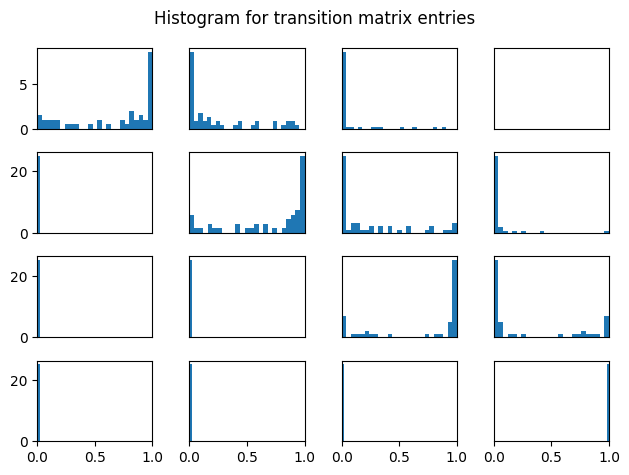

In [14]:

fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        axs[i,j].hist(T_arr[:,i,j], density=True, bins=25)
        axs[i,j].set_xlim(0,1)
        axs[i,j].vlines(np.mean(T_arr[:,i,j]), *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="-.")
        if j != 0:
            axs[i,j].set_yticks([])
        if i != n - 1:
            axs[i,j].set_xticks([])
            
fig.suptitle(f"Histogram for transition matrix entries")
plt.tight_layout()
plt.show()

Fitting a mixture of Gaussians using the scipy `gaussian_kde` command reveals that the peaks of the densities align quite closely to the true parameters, but there is considerable variance in the estimate.

In [15]:
from scipy.stats import gaussian_kde

T_distr = np.zeros_like(T).tolist()
for s in range(n - 1):
    for s_prime in range(s, n):
        T_distr[s][s_prime] = gaussian_kde(T_arr[:, s, s_prime])

O_distr = np.zeros_like(O).tolist()
for s in range(n):
    for o in range(m):
            if len(set(O_arr[:, s, o].astype(np.float32))) >= 1:
                 O_distr[s][0] = lambda x: 1.0*(np.isclose(x, O_arr[0, s, o]))
            else:
                O_distr[s][o] = gaussian_kde(O_arr[:, s, o].astype(np.float32))

ValueError: array must not contain infs or NaNs

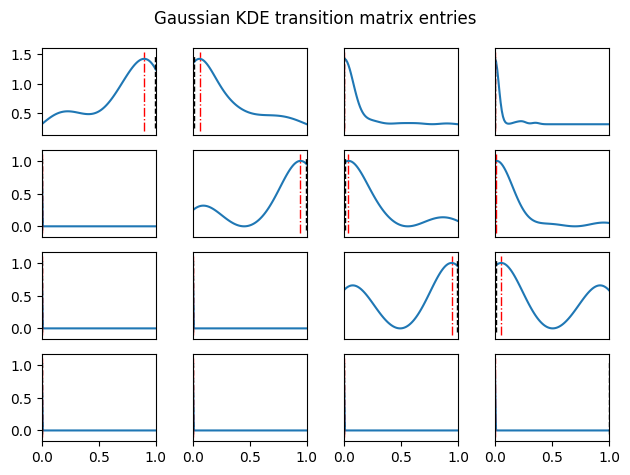

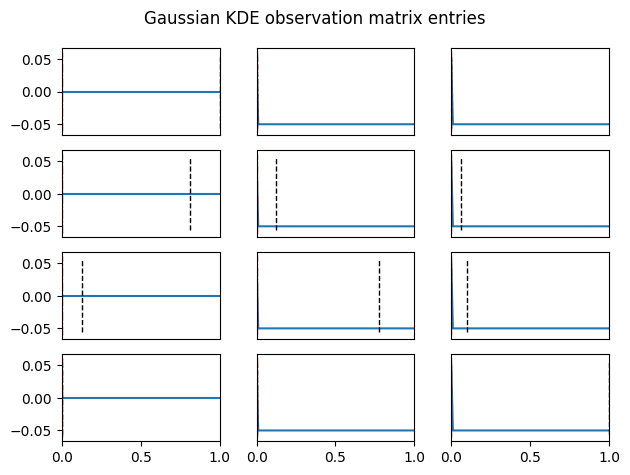

/tmp/ipykernel_4793/2100162364.py:58: RuntimeWarning: invalid value encountered in divide
  O_mle = O_mle / np.sum(O_mle, axis=-1)[..., None]


In [ ]:

xs = np.linspace(0,1,100)
T_mle = np.zeros_like(T)
T_mle[-1, -1] = 1.0

fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        try:
            density = T_distr[i][j](xs)
            maximum_likelihood = xs[np.argmax(density)]
            T_mle[i,j] = maximum_likelihood
        except TypeError:
            density = np.zeros_like(xs)
            density[0] = 1.0
            maximum_likelihood = 0.0
        axs[i,j].plot(xs, density)
        axs[i,j].set_xlim(0,1)
        axs[i,j].vlines(T[i,j], *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="--")
        axs[i,j].vlines(maximum_likelihood, *axs[i,j].get_ylim(), "r", linewidth=1.0, linestyle="-.")
        if j != 0:
            axs[i,j].set_yticks([])
        if i != n - 1:
            axs[i,j].set_xticks([])
  
fig.suptitle(f"Gaussian KDE transition matrix entries")
plt.tight_layout()
plt.show()


O_mle = np.zeros_like(O)

fig, axs = plt.subplots(n, m)
for i in range(n):
    for j in range(m):
        try:
            density = O_distr[i][j](xs)
            maximum_likelihood = xs[np.argmax(density)]
            O_mle[i,j] = maximum_likelihood
        except TypeError:
            density = np.zeros_like(xs)
            density[0] = 1.0
            maximum_likelihood = 0.0
        axs[i,j].plot(xs, density)
        axs[i,j].set_xlim(0,1)
        axs[i,j].vlines(O[i,j], *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="--")
        axs[i,j].vlines(maximum_likelihood, *axs[i,j].get_ylim(), "r", linewidth=1.0, linestyle="-.")
        if j != 0:
            axs[i,j].set_yticks([])
        if i != n - 1:
            axs[i,j].set_xticks([])
  
fig.suptitle(f"Gaussian KDE observation matrix entries")
plt.tight_layout()
plt.show()


T_mle = T_mle / np.sum(T_mle, axis=-1)[..., None]
O_mle = O_mle / np.sum(O_mle, axis=-1)[..., None]

It becomes clear with the next plot that simply averaging the results of the algorithm does in fact not produce a very good approximation of T, and instead the maximum likelihood estimate must be used.

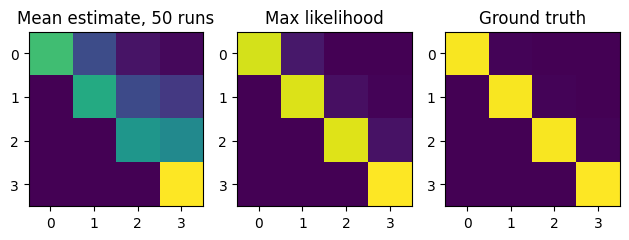

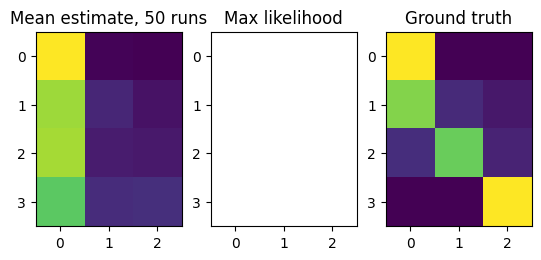

In [ ]:
T_mean = np.mean(T_arr[5:195], axis=0)
O_mean = np.mean(O_arr[5:195], axis=0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(T_mean)
ax[1].imshow(T_mle)
ax[2].imshow(T)
ax[0].set_title(f"Mean estimate, {n_trials} runs")
ax[1].set_title("Max likelihood")
ax[2].set_title("Ground truth")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,3)
ax[0].imshow(O_mean)
ax[1].imshow(O_mle)
ax[2].imshow(O)
ax[0].set_title(f"Mean estimate, {n_trials} runs")
ax[1].set_title("Max likelihood")
ax[2].set_title("Ground truth")
plt.show()

In [ ]:
print("Mean:\n", T_mean, "\n\nMLE:\n", T_mle, "\n\nTrue:\n", T)

Mean:
 [[0.692 0.233 0.054 0.02 ]
 [0.    0.61  0.225 0.165]
 [0.    0.    0.526 0.474]
 [0.    0.    0.    1.   ]] 

MLE:
 [[0.937 0.063 0.    0.   ]
 [0.    0.949 0.041 0.01 ]
 [0.    0.    0.949 0.051]
 [0.    0.    0.    1.   ]] 

True:
 [[0.99 0.01 0.   0.  ]
 [0.   0.99 0.01 0.  ]
 [0.   0.   0.99 0.01]
 [0.   0.   0.   1.  ]]


In [ ]:
result_mean = jax.vmap(lambda _key: generate_sequence(_key, T_mean, O_mean, mu, len_sequence))(jnp.array(sequence_keys))
result_mle = jax.vmap(lambda _key: generate_sequence(_key, T_mle, O_mean, mu, len_sequence))(jnp.array(sequence_keys))

In [ ]:
states_mean, obs_mean = result_mean
states_mle, obs_mle = result_mle

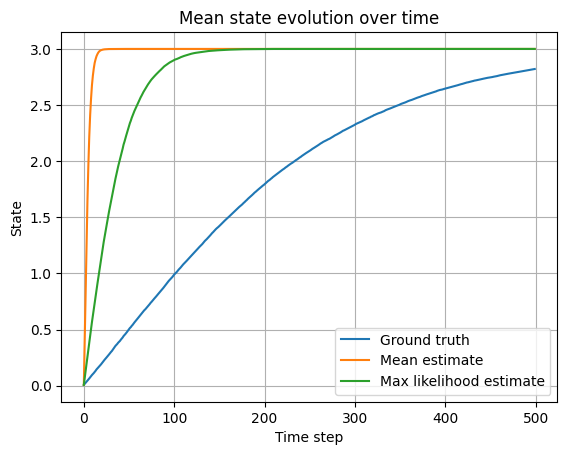

In [ ]:
plt.title("Mean state evolution over time")
plt.plot(jnp.mean(states, axis=0), label="Ground truth")
plt.plot(jnp.mean(states_mean, axis=0), label="Mean estimate")
plt.plot(jnp.mean(states_mle, axis=0), label="Max likelihood estimate")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("State")
# plt.xlim(-10,1000)
plt.legend()
plt.show()

#### Making it run on GPU

To adapt the algorithm for the GPU using JAX, some improvements have to be made, and loops should be avoided at all costs.



In [ ]:
# Quick experiment to see if some operations are equivalent

t_max = len(test_obs)
ovec = np.zeros((t_max, n))

for t in range(1, t_max):
    ovec[t_max - t] = _O[:, test_obs[t_max - t]]

# ovec_other = O[:, test_obs].T
ovec_other = np.take(_O, test_obs[1:], axis=1).T

print(ovec_other.shape)
print(ovec.shape)
print(np.allclose(ovec[1:], ovec_other))

gamma = jnp.arange(t_max * n).reshape((t_max, n))
output = np.ones((n,m))

for o in range(m):
    idx_filter = (test_obs == o)
    output[:, o] = np.sum(gamma[idx_filter], axis=0)

output_other = lax.map(lambda o:(test_obs == o) @ gamma, jnp.arange(m)).T

jnp.allclose(output, output_other)

(99, 4)
(100, 4)
True


Array(True, dtype=bool)

In [ ]:
def normalize_rows(vec: Array) -> Array:
    sum_vec = jnp.sum(vec, axis=-1)
    return lax.cond(
        jnp.allclose(sum_vec, 0.0),
        lambda: jnp.zeros_like(vec),
        lambda: vec / sum_vec[..., None]
    )

@partial(jax.jit, static_argnames=["max_iter", "epsilon"])
def forward_backward(
    obs: Array, 
    mu: Array, 
    T_0: Array, 
    O_0: Array, 
    max_iter=100, 
    epsilon=1e-4) -> tuple[Array, Array]:
    
    t_max = len(obs)
    n, m = O_0.shape

    def iteration(carry: tuple[Array, Array], _: None) -> tuple[Array, Array]:

        _T, _O = carry

        # Initial forward probabilities for the loop
        alpha_0 = mu * _O[:, obs[0]]
        alpha_0 = normalize_rows(alpha_0)

        # initialize backward probabilities
        beta_t_max = jnp.ones(n) / n

        t_range = jnp.arange(1, t_max)

        def step(carry, t):
            alpha, beta = carry

            alpha = (alpha @ _T) * _O[:, obs[t]]
            beta  = _T @ (_O[:, obs[t_max - t]] * beta)

            alpha = normalize_rows(alpha)
            beta = normalize_rows(beta)

            return (alpha, beta), (alpha, beta)
        
        _, (alpha, beta) = lax.scan(
            step,
            (alpha_0, beta_t_max),
            t_range
        )

        alpha = jnp.concat([alpha_0[None,:], alpha])
        beta = jnp.concat([beta_t_max[None,:], beta])

        beta = jnp.flip(beta, axis=0)


        likelihood = jnp.sum(alpha[t_max - 1])
        gamma = (alpha * beta) / (likelihood + epsilon)

        # Calculation of the xi tensor involves taking the outer product of alpha and O * beta 
        # for each combination of alpha_t and beta_t+1
        obs_probs = jnp.take(_O, obs[1:], axis=1).T
        xi = jnp.einsum("ij, ik->ijk", alpha[:-1], beta[1:] * obs_probs)

        # and then multiplying each slice componentwise with _T
        xi = xi * _T[None, ...]

        # Now by averaging over all time steps and normalizing along the rows,
        # a new estimate for T is obtained
        _T = jnp.sum(xi, axis=0) 
        _T = normalize_rows(_T) 

        _O = lax.map(lambda o: jnp.sum((obs == o)[:, None] * gamma, axis=0), jnp.arange(m)).T
        _O = normalize_rows(_O)
        # _O = _O / np.sum(gamma, axis=0)[..., None]

        return (_T, _O), (_T, _O)

    (_T, _O), (seq_T, seq_O) = lax.scan(
        iteration, 
        init=(T_0.copy(), O_0.copy()),
        length=max_iter
    )       

    # Pick the first index where the max difference between subsequent iterations is below epsilon
    convergence_idx = jnp.argmax(jnp.max(jnp.abs(jnp.diff(seq_T, 1, axis=0)), axis=(1,2)) < epsilon) 

    return seq_T[convergence_idx], seq_O[convergence_idx]

In [ ]:
_T, _O = forward_backward(test_obs, mu, np.triu(jrng.uniform(key_0, T.shape)), jrng.uniform(key_1, O.shape))

In [ ]:
n_trials = 50

def fit(obs, rng_key):
    key_0, key_1 = jrng.split(rng_key)
    return forward_backward(obs, mu, jnp.triu(jrng.uniform(key_0, T.shape)), jrng.uniform(key_1, O.shape))

key, *keys = jrng.split(key, n_trials + 1)

jax_result = jax.vmap(fit)(observations[:n_trials, :500], jnp.array(keys))

In [ ]:
T_arr, O_arr = jax_result

In [ ]:
valid_indices = jnp.sum(jnp.isnan(T_arr), axis=(-1,-2)) == 0

T_arr[valid_indices, -1, -1].shape

(10,)

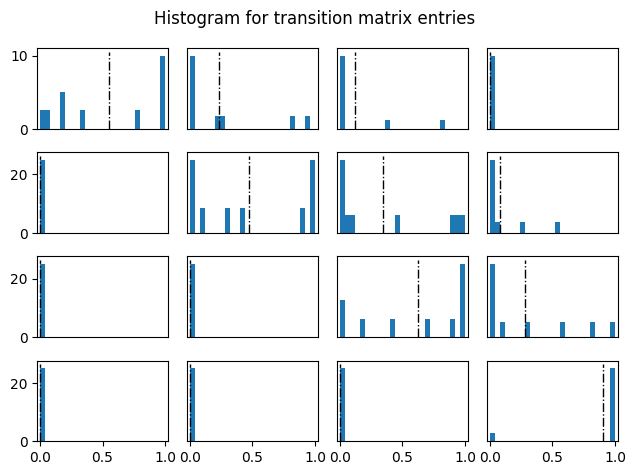

In [ ]:
fig, axs = plt.subplots(n, n)
valid_indices = jnp.sum(jnp.isnan(T_arr), axis=(-1,-2)) == 0

for i in range(n):
    for j in range(n):
        axs[i,j].hist(np.array(T_arr[valid_indices,i,j]), density=True, bins=25, range=(0.0,1.0))

        axs[i,j].set_xlim(-0.02,1.02)
        axs[i,j].vlines(np.mean(T_arr[valid_indices,i,j]), *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="-.")
        if j != 0:
            axs[i,j].set_yticks([])
        if i != n - 1:
            axs[i,j].set_xticks([])
            
fig.suptitle(f"Histogram for transition matrix entries")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import gaussian_kde

valid_indices = jnp.sum(jnp.isnan(T_arr), axis=(-1,-2)) == 0

T_distr = np.zeros_like(T).tolist()
for s in range(n - 1):
    for s_prime in range(s, n):
        T_distr[s][s_prime] = gaussian_kde(T_arr[valid_indices, s, s_prime], bw_method="silverman")

O_distr = np.zeros_like(O).tolist()
for s in range(n):
    for o in range(m):
        O_distr[s][o] = gaussian_kde(O_arr[valid_indices, s, o])

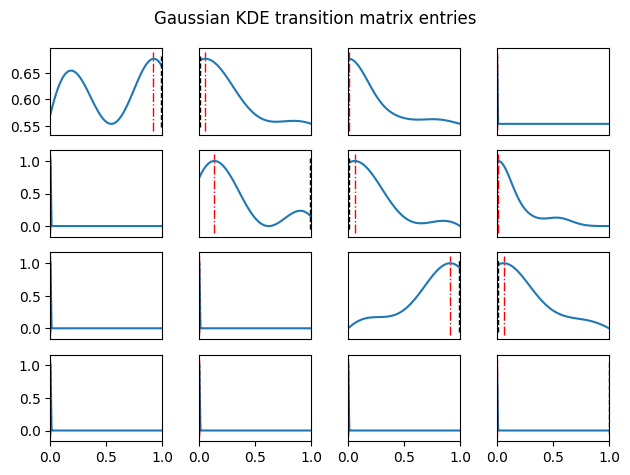

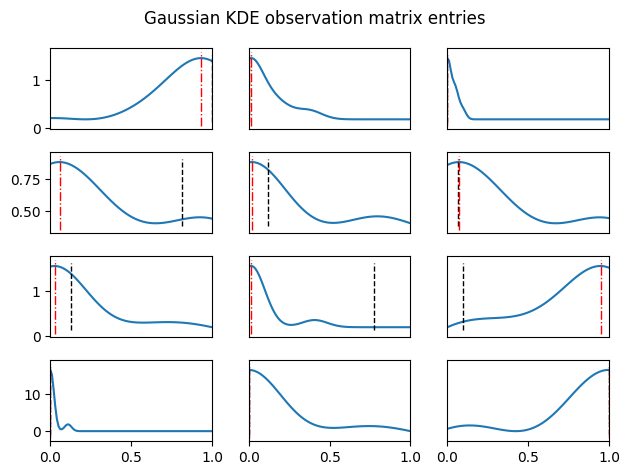

In [ ]:

xs = np.linspace(0,1,100)
T_mle = np.zeros_like(T)
T_mle[-1, -1] = 1.0

fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        try:
            density = T_distr[i][j](xs)
            maximum_likelihood = xs[np.argmax(density)]
            T_mle[i,j] = maximum_likelihood
        except TypeError:
            density = np.zeros_like(xs)
            density[0] = 1.0
            maximum_likelihood = 0.0
        axs[i,j].plot(xs, density)
        axs[i,j].set_xlim(0,1)
        axs[i,j].vlines(T[i,j], *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="--")
        axs[i,j].vlines(maximum_likelihood, *axs[i,j].get_ylim(), "r", linewidth=1.0, linestyle="-.")
        if j != 0:
            axs[i,j].set_yticks([])
        if i != n - 1:
            axs[i,j].set_xticks([])
  
fig.suptitle(f"Gaussian KDE transition matrix entries")
plt.tight_layout()
plt.show()


O_mle = np.zeros_like(O)

fig, axs = plt.subplots(n, m)
for i in range(n):
    for j in range(m):
        try:
            density = O_distr[i][j](xs)
            maximum_likelihood = xs[np.argmax(density)]
            O_mle[i,j] = maximum_likelihood
        except TypeError:
            density = np.zeros_like(xs)
            density[0] = 1.0
            maximum_likelihood = 0.0
        axs[i,j].plot(xs, density)
        axs[i,j].set_xlim(0,1)
        axs[i,j].vlines(O[i,j], *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="--")
        axs[i,j].vlines(maximum_likelihood, *axs[i,j].get_ylim(), "r", linewidth=1.0, linestyle="-.")
        if j != 0:
            axs[i,j].set_yticks([])
        if i != n - 1:
            axs[i,j].set_xticks([])
  
fig.suptitle(f"Gaussian KDE observation matrix entries")
plt.tight_layout()
plt.show()


T_mle = T_mle / np.sum(T_mle, axis=-1)[..., None]
O_mle = O_mle / np.sum(O_mle, axis=-1)[..., None]

In [ ]:
T_mle

array([[0.938, 0.052, 0.01 , 0.   ],
       [0.   , 0.65 , 0.3  , 0.05 ],
       [0.   , 0.   , 0.938, 0.062],
       [0.   , 0.   , 0.   , 1.   ]], dtype=float32)

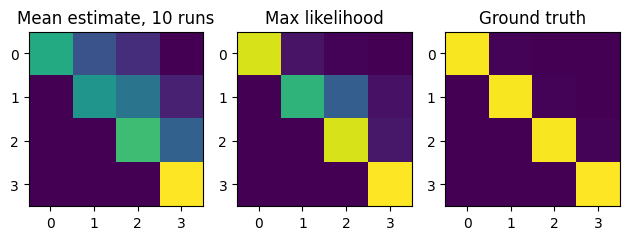

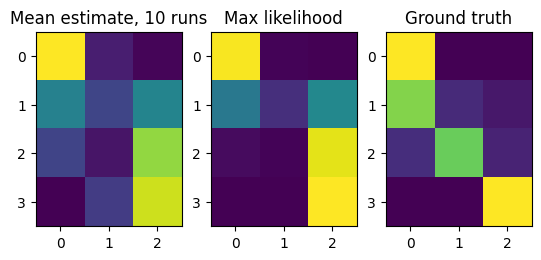

In [ ]:
T_mean = np.mean(T_arr[valid_indices], axis=0)
O_mean = np.mean(O_arr[valid_indices], axis=0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(T_mean, cmap="viridis")
ax[1].imshow(T_mle, cmap="viridis")
ax[2].imshow(T, cmap="viridis")
ax[0].set_title(f"Mean estimate, {n_trials} runs")
ax[1].set_title("Max likelihood")
ax[2].set_title("Ground truth")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,3)
ax[0].imshow(O_mean, cmap="viridis")
ax[1].imshow(O_mle, cmap="viridis")
ax[2].imshow(O, cmap="viridis")
ax[0].set_title(f"Mean estimate, {n_trials} runs")
ax[1].set_title("Max likelihood")
ax[2].set_title("Ground truth")
plt.show()

In [ ]:
print("Mean:\n", T_mean, "\n\nMLE:\n", T_mle, "\n\nTrue:\n", T)

Mean:
 [[5.499e-01 2.313e-01 1.186e-01 2.623e-04]
 [0.000e+00 4.688e-01 3.469e-01 8.427e-02]
 [0.000e+00 0.000e+00 6.215e-01 2.785e-01]
 [0.000e+00 0.000e+00 0.000e+00 9.000e-01]] 

MLE:
 [[0.938 0.052 0.01  0.   ]
 [0.    0.65  0.3   0.05 ]
 [0.    0.    0.938 0.062]
 [0.    0.    0.    1.   ]] 

True:
 [[0.99 0.01 0.   0.  ]
 [0.   0.99 0.01 0.  ]
 [0.   0.   0.99 0.01]
 [0.   0.   0.   1.  ]]


In [ ]:
result_mean = jax.vmap(lambda _key: generate_sequence(_key, T_mean, O_mean, mu, len_sequence))(jnp.array(sequence_keys))
result_mle = jax.vmap(lambda _key: generate_sequence(_key, T_mle, O_mean, mu, len_sequence))(jnp.array(sequence_keys))

In [ ]:
states_mean, obs_mean = result_mean
states_mle, obs_mle = result_mle

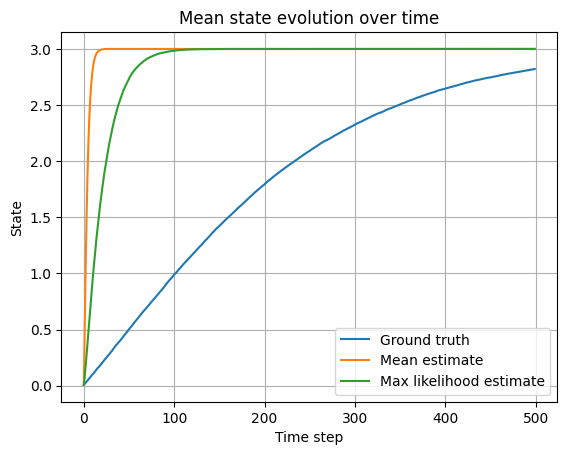

: 

In [ ]:
plt.title("Mean state evolution over time")
plt.plot(jnp.mean(states, axis=0), label="Ground truth")
plt.plot(jnp.mean(states_mean, axis=0), label="Mean estimate")
plt.plot(jnp.mean(states_mle, axis=0), label="Max likelihood estimate")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("State")
# plt.xlim(-10,1000)
plt.legend()
plt.show()

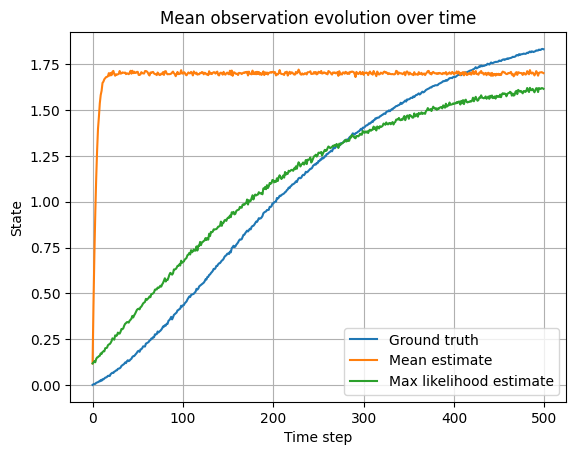

In [ ]:
plt.title("Mean observation evolution over time")
plt.plot(jnp.mean(observations, axis=0), label="Ground truth")
plt.plot(jnp.mean(obs_mean, axis=0), label="Mean estimate")
plt.plot(jnp.mean(obs_mle, axis=0), label="Max likelihood estimate")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("State")
# plt.xlim(-10,1000)
plt.legend()
plt.show()

In [ ]:
T_means = jnp.mean(T_arr[valid_indices], axis=0)
T_vars = jnp.var(T_arr[valid_indices], axis=0)

# Only holds if the following condition is true!
print(T_vars < (T_means * (1 - T_means)))

a = T_means * ((T_means * (1 - T_means))/T_vars - 1)
b = (1 - T_means) * ((T_means * (1 - T_means))/T_vars - 1)



[[ True  True  True  True]
 [False  True  True  True]
 [False False  True  True]
 [False False False  True]]


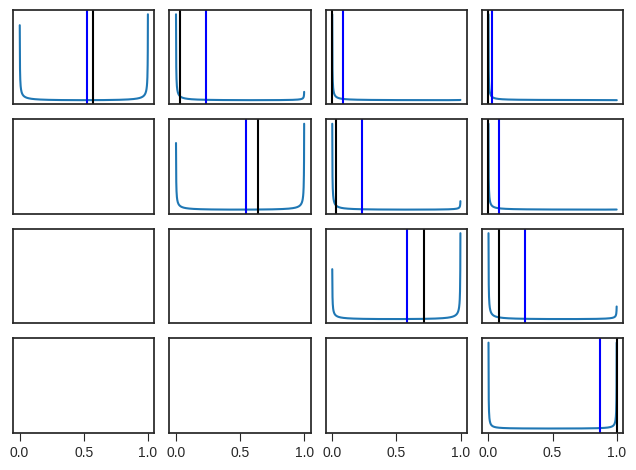

In [ ]:
from scipy.stats import beta

fig, ax = plt.subplots(n,n)
for i in range(n):
    for j in range(n):
        xs = np.linspace(0,1, 1000)
        distr = beta(a[i,j], b[i,j])
        ax[i,j].plot(xs, distr.pdf(xs))
        ylim = ax[i,j].get_ylim()
        ax[i,j].vlines(distr.median(), *ax[i,j].get_ylim(), "k", label="median")
        ax[i,j].vlines(distr.mean(), *ax[i,j].get_ylim(), "b", label="mean")
        # ax[i,j].vlines((a[i,j] - 1)/(a[i,j] + b[i,j] - 2), *ax[i,j].get_ylim(), "r", label="mean")
        ax[i,j].set_xlim(-0.05,1.05)
        ax[i,j].set_ylim(*ylim)
        ax[i,j].set_yticks([])
        if i != n - 1:
            ax[i,j].set_xticks([])
plt.tight_layout()
plt.show()

Now that we have an implementation, compare it with something off the shelf:

In [ ]:
from pyhhmm.gaussian import GaussianHMM
from pyhhmm.multinomial import MultinomialHMM
from pyhhmm.heterogeneous import HeterogeneousHMM
import pyhhmm.utils as hu

print(observations.shape)


(10000, 500)


Initialisation 1
iter: 0, log_likelihood = -64010.05920919693, delta = nan
iter: 1, log_likelihood = -46817.62998792065, delta = 17192.42922127628
iter: 2, log_likelihood = -37763.12594400613, delta = 9054.504043914516
iter: 3, log_likelihood = -26451.185030110435, delta = 11311.940913895698
iter: 4, log_likelihood = -20168.956985569937, delta = 6282.228044540498
iter: 5, log_likelihood = -16630.14093069357, delta = 3538.8160548763663
iter: 6, log_likelihood = -15310.239266012703, delta = 1319.9016646808686
iter: 7, log_likelihood = -14845.651976844803, delta = 464.58728916789914
iter: 8, log_likelihood = -14630.482569498034, delta = 215.16940734676973
iter: 9, log_likelihood = -14514.92522849664, delta = 115.55734100139307
iter: 10, log_likelihood = -14449.501118369559, delta = 65.4241101270818
iter: 11, log_likelihood = -14411.705816203055, delta = 37.79530216650346
iter: 12, log_likelihood = -14389.26391342071, delta = 22.441902782346006
iter: 13, log_likelihood = -14375.43476291740

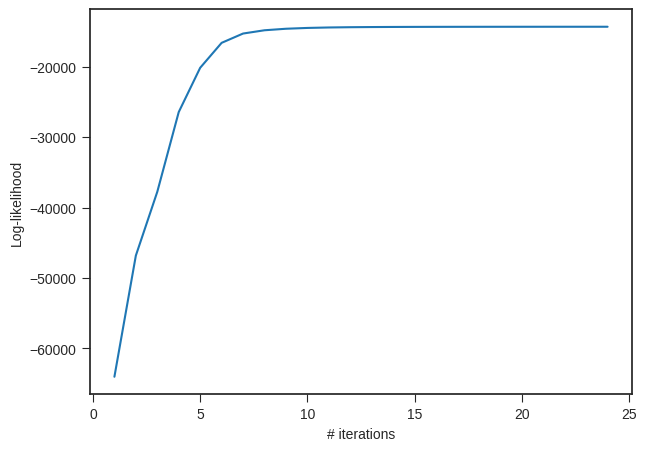

In [ ]:

# instantiate a MultinomialHMM object
trained_hmm = MultinomialHMM(
    # number of hidden states (H and C)
    n_states=4,     
    # number of discrete emissions (how many ice creams Jason ate)
    n_emissions=1,
    # length of the observation alphabet (O = {1, 2, 3}, which becomes {0, 1, 2})
    n_features=[3],
    # type of initialisation to use; can be 'uniform' or 'random'
    init_type='random',

    tr_params="te"
)

trained_hmm.pi = np.array(mu)

# reinitialise the parameters and see if we can re-learn them
trained_hmm, log_likelihoods = trained_hmm.train(
    [np.array(obs.reshape((500, 1))) for obs in observations[:100]],
    n_init=1,     # no. of initialisations - we only do it once this time; if multiple initialisations are used, the model with the best log-likelihood will be returned
    n_iter=100,   # maximum no. of iterations to use
    conv_thresh=1e-04,   # convergence threshold (in this case if the change in consecutive log-likelihood is < 0.1%)
    conv_iter=5,  # no. of iterations for which the convergence criteria should hold before stopping
    plot_log_likelihood=True, # if we want a plot of the log-likelihood evolution over the iterations
)

In [ ]:
hu.pretty_print_hmm(trained_hmm)

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.003 | P(S_1)=0.278 | P(S_2)=0.395 | P(S_3)=0.324 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.452 | P(S_1|S_0)=0.012 | P(S_2|S_0)=0.524 | P(S_3|S_0)=0.012 |
| S_1 | P(S_0|S_1)=0.010 | P(S_1|S_1)=0.157 | P(S_2|S_1)=0.010 | P(S_3|S_1)=0.824 |
| S_2 | P(S_0|S_2)=0.617 | P(S_1|S_2)=0.014 | P(S_2|S_2)=0.354 | P(S_3|S_2)=0.014 |
| S_3 | P(S_0|S_3)=0.005 | P(S_1|S_3)=0.419 | P(S_2|S_3)=0.005 | P(S_3|S_3)=0.572 |
+-----+------------------+------------------+------------------+------------------+

In [ ]:
T_pyhhmm = trained_hmm.A
O_pyhhmm = trained_hmm.B[0]

In [ ]:
T_pyhhmm, O_pyhhmm

(array([[0.452, 0.012, 0.524, 0.012],
        [0.01 , 0.157, 0.01 , 0.824],
        [0.617, 0.014, 0.354, 0.014],
        [0.005, 0.419, 0.005, 0.572]]),
 array([[6.217e-01, 2.960e-01, 8.227e-02],
        [2.702e-13, 1.646e-12, 1.000e+00],
        [6.415e-01, 3.337e-01, 2.481e-02],
        [1.980e-14, 2.306e-13, 1.000e+00]]))

In [ ]:
mu

Array([9.933e-01, 6.693e-03, 4.509e-05, 0.000e+00], dtype=float32)